In [1]:
# truncate each suffix hyp in the n-best list according to some heuristic with respect to the costs
# visualize heatmap of confidence per-word -- visualize how this corresponds to optimal hypothesis truncation
# evaluate performance as the heuristic changes

In [2]:
# now graph f1, precision, recall over threshold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pylab
pylab.rcParams['figure.figsize'] = (14.0, 12.0)
pylab.rcParams['axes.linewidth'] = 2. #set the value globally
params = {'legend.fontsize': 20}
#           'legend.linewidth': 2}
pylab.rcParams.update(params)

In [3]:
import codecs
import numpy
import os

In [4]:
# newstest 2014
# BASEDIR ='/media/1tb_drive/imt_models/newstest_2014_evaluation/'

# BASEDIR ='/media/1tb_drive/imt_models/EN-DE-confidence-3layer_FINAL_STATES_l2_reg_model_baseline_internal_data_dropout0.5_' + \
#          'src_vocab80000_trg_vocab90000_emb300_rec1000_batch50'



# HYP_BASEDIR = '/media/1tb_drive/imt_models/EN-DE-confidence-3layer_FINAL_STATES_PREDICTION_65000_iters_model_baseline_internal_data_dropout1.0_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50'
# BASEDIR ='/media/1tb_drive/imt_models/EN-DE-confidence-3layer-baseline-PREDICTION_internal_data_dropout1.0_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50/'
# hyps_file = os.path.join(HYP_BASEDIR, 'newstest2014.de.500.bpe.imt-hyps.out')

# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.75000_iters.npz')
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.100000_iters.npz')
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.15000_iters.npz')

# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained_10000_iters.npz')
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained_40000_iters.npz')
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained_90000_iters.npz')

# w/ softmax feature
# BASEDIR ='/media/1tb_drive/imt_models/EN-DE-confidence-3layer_FINAL_STATES_AND_SOFTMAX_l2_reg_model_internal_' + \
#         'data_dropout0.5_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50/'
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained.5000_iters.npz')
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained.25000_iters.npz')
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained.30000_iters.npz')
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained.35000_iters.npz')

# w/ real dropout = 0.2
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained.10000_iters.npz')
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained.30000_iters.npz')




# w/ real dropout = 0.5
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained.35000_iters.npz')
# confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained.10000_iters.npz')

# Final Evaluation:
# w/ softmax feature and dropout = 0.5
BASEDIR='/home/chris/Desktop/Dropbox/thesis/archived_models/imt_confidence_models/' + \
'EN-DE-confidence-3layer_FINAL_STATES_AND_SOFTMAX_l2_reg_model_internal_data_dropout0.5' + \
'_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50'
confidences_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-confidences.prediction_trained.10000_iters.npz')
#HYP_BASEDIR = '/media/1tb_drive/imt_models/EN-DE-confidence-3layer_FINAL_STATES_PREDICTION_65000_iters_model_baseline_internal_data_dropout1.0_src_vocab80000_trg_vocab90000_emb300_rec1000_batch50'
#hyps_file = os.path.join(HYP_BASEDIR, 'newstest2014.de.500.bpe.imt-hyps.out')
hyps_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-hyps.out')

wl_costs_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-word_level_costs.npz')

source_file = os.path.join(BASEDIR, 'newstest2014.de.500.bpe.imt-sources.out')
refs_file = os.path.join(BASEDIR, 'reference_suffixes.generated')

prefixes_file = os.path.join(BASEDIR, 'reference_prefixes.generated')

# newstest 2015
# BASEDIR ='/media/1tb_drive/imt_models/newstest_2015_evaluation/'

# hyps_file = os.path.join(BASEDIR, 'newstest2015.de.500.bpe.imt-hyps.out')
# glimpse_file = os.path.join(BASEDIR, 'newstest2015.de.500.bpe.imt-glimpses.out')
# source_file = os.path.join(BASEDIR, 'newstest2015.de.500.bpe.imt-sources.out')
# refs_file = os.path.join(BASEDIR, 'reference_suffixes.generated')

In [5]:
def get_lines(filename, lower=False, cutoff=None):
    with codecs.open(filename) as inp:
        lines = [l.split() for l in inp.read().strip().split('\n')][:cutoff]
        if lower:
            lines = [[w.lower() for w in l] for l in lines]
        return lines

In [6]:
orig_hyp_lines = get_lines(hyps_file)
orig_ref_lines = get_lines(refs_file)
orig_source_lines = get_lines(source_file)
orig_prefix_lines = get_lines(prefixes_file)

orig_word_level_confs = [l[0] for l in numpy.load(open(confidences_file))]

In [7]:
type(orig_word_level_confs[0])

list

In [8]:
# WORKING: evaluate use of word-level confs
# HACKED HERE - WATCH THE NAME
# costs are negative log probabilities, so convert them back to probailities
orig_word_level_costs = [list(np.exp(-np.array(l[0]))) for l in numpy.load(open(wl_costs_file))]

# orig_word_level_confs = [list(np.exp(-np.array(l[0]))) for l in numpy.load(open(wl_costs_file))]
# orig_word_level_confs = [np.random.random(len(l)) for l in orig_word_level_confs]


In [9]:
for p,c in zip(orig_hyp_lines, orig_word_level_confs):               
    try:
        assert len(p) == len(c)
    except AssertionError:
        print('P: {}, C: {}'.format(p,c))

In [16]:
orig_word_level_confs[:4]

[[0.14305685,
  0.80857545,
  0.79699302,
  0.15560581,
  0.74367094,
  0.69421959,
  0.72801399,
  0.95534259],
 [0.80857545,
  0.79699302,
  0.15560581,
  0.74367094,
  0.69421959,
  0.72801399,
  0.95534259],
 [0.79699302, 0.15560581, 0.74367094, 0.69421959, 0.72801399, 0.95534259],
 [0.15560581, 0.74367094, 0.69421959, 0.72801399, 0.95534259]]

In [18]:
type(orig_word_level_costs)

list

In [27]:
word_cost_lines = [zip(hyp, ref_line, wl_costs) for hyp, ref_line, wl_costs in zip(orig_hyp_lines, orig_ref_lines, orig_word_level_costs)]
word_conf_lines = [zip(hyp, ref_line, wl_costs) for hyp, ref_line, wl_costs in zip(orig_hyp_lines, orig_ref_lines, orig_word_level_confs)]

In [28]:
word_cost_lines[:3]

[[('Gut@@', 'Gut@@', 0.95099431),
  ('ach', 'ach', 0.98607504),
  (':', ':', 0.99800879),
  ('Mehr', 'Noch', 0.13394342),
  ('Sicherheit', 'mehr', 0.97616267),
  ('f\xc3\xbcr', 'Sicherheit', 0.95611227),
  ('Fu\xc3\x9fg\xc3\xa4nger', 'f\xc3\xbcr', 0.60691315),
  ('</S>', 'Fu\xc3\x9fg\xc3\xa4nger', 0.99937075)],
 [('ach', 'ach', 0.98607504),
  (':', ':', 0.99800879),
  ('Mehr', 'Noch', 0.13394329),
  ('Sicherheit', 'mehr', 0.97616267),
  ('f\xc3\xbcr', 'Sicherheit', 0.95611227),
  ('Fu\xc3\x9fg\xc3\xa4nger', 'f\xc3\xbcr', 0.60691196),
  ('</S>', 'Fu\xc3\x9fg\xc3\xa4nger', 0.99937075)],
 [(':', ':', 0.99800879),
  ('Mehr', 'Noch', 0.13394316),
  ('Sicherheit', 'mehr', 0.97616267),
  ('f\xc3\xbcr', 'Sicherheit', 0.95611227),
  ('Fu\xc3\x9fg\xc3\xa4nger', 'f\xc3\xbcr', 0.60691315),
  ('</S>', 'Fu\xc3\x9fg\xc3\xa4nger', 0.99937075)]]

In [32]:
# mean confidence of wrong vs mean confidence of right
wrong_probs = [v for r in word_cost_lines for hyp_w, ref_w, v  in r if hyp_w != ref_w]
print('Avg model probability of wrong predictions: {}'.format(numpy.mean(wrong_probs)))
right_probs = [v for r in word_cost_lines for hyp_w, ref_w, v  in r if hyp_w == ref_w]
print('Avg model probability of correct predictions: {}'.format(numpy.mean(right_probs)))

wrong_confs = [v for r in word_conf_lines for hyp_w, ref_w, v  in r if hyp_w != ref_w]
print('Avg confidence of wrong predictions: {}'.format(numpy.mean(wrong_confs)))
right_confs = [v for r in word_conf_lines for hyp_w, ref_w, v  in r if hyp_w == ref_w]
print('Avg confidence of correct predictions: {}'.format(numpy.mean(right_confs)))

# TODO: correlation between confidence and model probability
from scipy.stats import pearsonr
conf_model_values = [v for r in word_conf_lines for hyp_w, ref_w, v  in r]
model_cost_values = [v for r in word_cost_lines for hyp_w, ref_w, v  in r]
conf_vs_cost_pearson = pearsonr(conf_model_values, model_cost_values)
assert len(model_cost_values) == len(conf_model_values)
print('total num predictions: {}'.format(len(conf_model_values)))
print('Pearson corr. between confidence model and IMT model cost: {}'.format(conf_vs_cost_pearson))



Avg model probability of wrong predictions: 0.604707598686
Avg model probability of correct predictions: 0.766623795033
Avg confidence of wrong predictions: 0.503387391567
Avg confidence of correct predictions: 0.62818980217
total num predictions: 179008
Pearson corr. between confidence model and IMT model cost: (0.84218478, 0.0)


In [35]:
sorted_cost, sorted_conf = zip(*sorted([(cost, conf) for cost, conf in zip(model_cost_values, conf_model_values)]))
sorted_cost[:10]

(0.0026667719,
 0.0026667733,
 0.0037965546,
 0.0042370493,
 0.0042686076,
 0.0046176556,
 0.0046176622,
 0.0046176664,
 0.0046878643,
 0.0047026989)

In [39]:
from scipy import stats

x = np.arange(0, len(conf_model_values), 100)

# sort pairs by cost ascending, select every k-th point for efficiency
sorted_cost, sorted_conf = zip(*sorted([(cost, conf) for cost, conf in zip(model_cost_values, conf_model_values)]))
sorted_cost = [sorted_cost[i] for i in x]
sorted_conf = [sorted_conf[i] for i in x]

slope, intercept, r_value, p_value, std_err = stats.linregress(x, sorted_conf)
conf_regression_line = slope*x+intercept

plt.plot(x, sorted_cost)
plt.plot(x, sorted_conf)
plt.plot(x, conf_regression_line)


plt.show()

NameError: name 'stats' is not defined

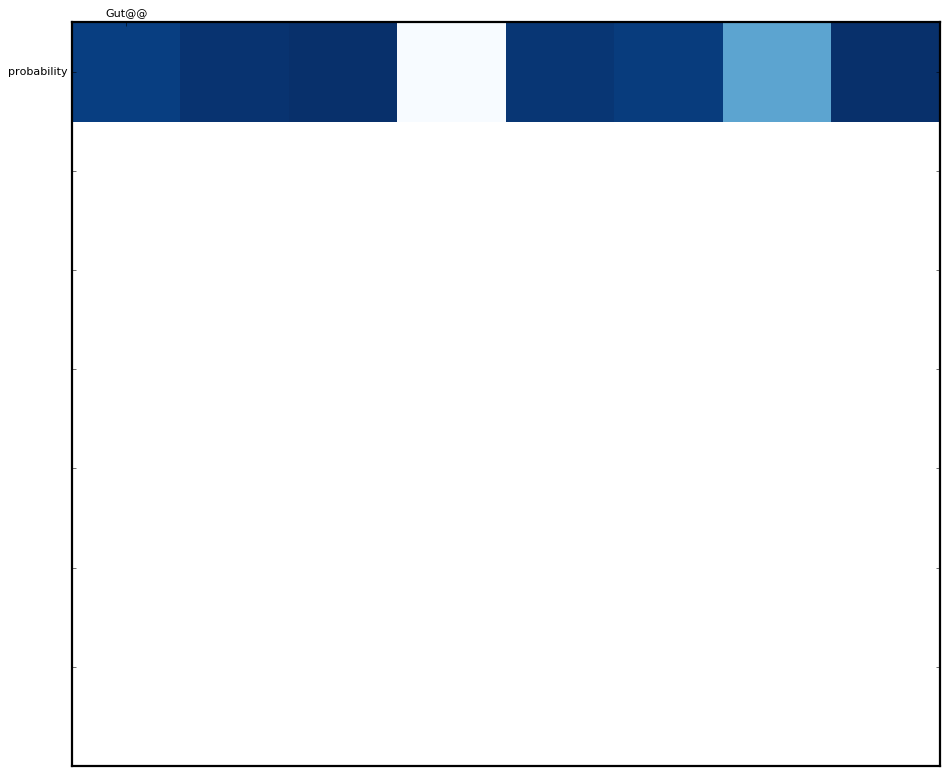

In [22]:
# hyp_words, ref_words, probs = zip(*word_cost_lines[0])

# row_labels = hyp_words
# column_labels = ['probability']
# data = np.random.rand(4,4)
# data = np.array(probs).reshape(1,len(probs))
# fig, ax = plt.subplots()
# heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# # put the major ticks at the middle of each cell
# ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
# ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

# # want a more natural, table-like display
# ax.invert_yaxis()
# ax.xaxis.tick_top()

# ax.set_xticklabels(row_labels)
# ax.set_yticklabels(column_labels, minor=False)
# plt.show()


In [70]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# data = [
#     go.Heatmap(
#         z=[[30, 60, 1, -10, 20]],
#         x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
#         y=['Morning']
#     )
# ]
# colorscale = [[0, 'red'], [1, 'green']]  # custom colorscale

# data = [
#     go.Heatmap(
#         z=[list(probs)],
#         x=list(hyp_words),
#         y=['probability'],
#         colorscale=colorscale
#     )
# ]


# py.iplot(data, filename='labelled-heatmap')
# print(ref_words)

In [71]:
# TRAINING SETUP BRAINSTORM
# for each hyp, for each position, evaluate whether the prediction was correct

# if the prediction was correct, this is a 1.

# if not, this is a 0.

# find the optimal coefficient/decision boundary for the single word-prob feature


In [72]:
# Now evaluate different pruning strategies
# BASELINE SCORES (NO TRUNCATION):INFO:__main__:IMT F1 SCORE: 0.244294277012, precision: 0.245880568086, recall: 0.244141178125

# TODO: cost is a better measure of risk?? -- what is the logic?

In [73]:
[len(l) for l in (orig_source_lines, orig_hyp_lines, orig_ref_lines, orig_word_level_confs, orig_prefix_lines)]

[12812, 12812, 12812, 12812, 12812]

In [74]:
orig_trans_tups = zip(orig_source_lines, orig_hyp_lines, orig_ref_lines, orig_word_level_confs, orig_prefix_lines)
print(len(orig_trans_tups))
# discard rows where nothing matches
matching_idxs = [idx for idx,t in enumerate(orig_trans_tups) if t[1][0] == t[2][0]]
non_matching_idxs = [idx for idx,t in enumerate(orig_trans_tups) if t[1][0] != t[2][0]]

# long_tups = [t for t in orig_trans_tups if len(t[1]) >= 7 and len(t[2]) >= 7]
# matching_2_idxs = [idx for idx,t in enumerate(long_tups) if t[1][6] == t[2][6]]
# non_2_matching_idxs = [idx for idx,t in enumerate(long_tups) if t[1][6] != t[2][6]]

trans_tups = [t for t in orig_trans_tups if t[1][0] == t[2][0]]
# trans_tups = orig_trans_tups

# Filter to only longer predictions
min_length_filter = 1
trans_tups = [t for t in trans_tups if len(t[1]) >= min_length_filter]
print(len(trans_tups))

# But make sure they're not ridiculously long
max_length_filter = 25
trans_tups = [t for t in trans_tups if len(t[1]) <= max_length_filter]
print(len(trans_tups))

source_lines, hyp_lines, ref_lines, word_level_confs, prefix_lines = zip(*trans_tups)

12812
6089
5137


In [75]:
from collections import Counter
Counter([len(t[1]) for t in trans_tups]).most_common()

[(1, 479),
 (2, 423),
 (4, 292),
 (3, 288),
 (5, 254),
 (7, 234),
 (6, 233),
 (8, 228),
 (9, 214),
 (12, 211),
 (11, 201),
 (10, 196),
 (14, 187),
 (13, 181),
 (16, 174),
 (15, 171),
 (17, 163),
 (19, 148),
 (18, 143),
 (20, 130),
 (23, 130),
 (21, 126),
 (22, 123),
 (24, 108),
 (25, 100)]

In [76]:
random_idxs = np.random.choice(len(trans_tups), size=10, replace=False)

In [77]:
random_idxs

array([3719,  266, 2103, 1057, 4696, 2808, 4009, 4467, 3351, 5055])

In [78]:
sample_tups = [trans_tups[idx] for idx in random_idxs]

In [79]:
for t in sample_tups:
    print(u"SRC: {}".format(' '.join(t[0])))
    print(u"PRE: {}".format(' '.join(t[-1])))
    print(u"HYP: {}".format(' '.join(t[1])))
    print(u"REF: {}".format(' '.join(t[2])))
    print('\n')

SRC: <S> Z@@ ita K@@ <UNK> , the Chair@@ person of the Parish Council , agreed to give a talk on Bi@@ blical pro@@ verb@@ s after breakfast . </S>
PRE: <S> Z@@ ita K@@ öhler , die Vorsitzende des Kirchen@@ gemein@@ de@@ - rats , ging nach dem Frühstück in einem Vortrag auf die bibli@@ schen Sprich@@ wörter ein
HYP: . </S>
REF: . </S>


SRC: <S> The catastrophes of his Catholic village up@@ bringing - the spe@@ ech@@ lessness , his tendency towards bru@@ te force and dul@@ led sexuality , the confin@@ ement and lack of joy - all of this has been described many times by the Ka@@ ern@@ ten-@@ born poet . </S>
PRE: <S> Die Katastrophen seiner katholischen Dorf@@ kind@@ heit - die Sprach@@ losigkeit , der Hang zu ro@@ her Gewalt und stum@@ pf@@ er Sexualität , die En@@ ge und Fre@@ ud@@ losigkeit - hat der Kärn@@ tner Dichter vielfach
HYP: beschrieben . </S>
REF: beschrieben . </S>


SRC: <S> The Nar@@ ren@@ zun@@ ft St@@ roh@@ gl@@ on@@ ki ( St@@ roh@@ gl@@ on@@ ki F@@ ool 's Guild celebra

In [80]:
random_s, random_h, random_r, random_c, random_p = zip(*sample_tups)
hyp_ref_conf = [zip(h, r, c1, c2) for h,r,c1,c2 in 
                zip(random_h, random_r, [np.exp(np.cumsum(np.log(conf))) for conf in random_c], random_c)]

In [81]:
# best thresh: 

for s in hyp_ref_conf:
    print('\n'.join(unicode(i) for i in s))
    print('\n\n')
# hyp_ref_conf[:10]

(u'.', u'.', 0.84726018, 0.84726018)
(u'</S>', u'</S>', 0.81697655, 0.964257)



(u'beschrieben', u'beschrieben', 0.30631727, 0.3063173)
(u'.', u'.', 0.28119463, 0.91798484)
(u'</S>', u'</S>', 0.27146229, 0.96538925)



(u'M\xe4rz', u'M\xe4rz', 0.84594959, 0.84594959)
(u'dieses', u'das', 0.27567583, 0.32587737)
(u'Jahr', u'Fest@@', 0.14177892, 0.51429582)
(u'zu', u'bank@@', 0.026616225, 0.18773048)
(u'feiern', u'ett', 0.013982063, 0.52532101)
(u'.', u'und', 0.01259432, 0.90074837)
(u'</S>', u'feiert', 0.012121725, 0.96247536)



(u'sein', u'sein', 0.43006381, 0.43006381)
(u'.', u'.', 0.19933277, 0.46349579)
(u'</S>', u'</S>', 0.18506782, 0.92843652)



(u'</S>', u'</S>', 0.95689154, 0.95689154)



(u'</S>', u'</S>', 0.96380103, 0.96380103)



(u'illu@@', u'illu@@', 0.27701902, 0.27701902)
(u'sion@@', u'sion@@', 0.10494244, 0.37882754)
(u'ierten', u'ierten', 0.059535429, 0.5673151)
(u'fr\xfcheren', u'ehemaligen', 0.015691938, 0.26357311)
(u'N@@', u'N@@', 0.0067147259, 0.42790934)
(u'SA-

In [82]:
# true_first_confs = [orig_trans_tups[idx][3][0] for idx in matching_idxs]
# wrong_first_confs = [orig_trans_tups[idx][3][0] for idx in non_matching_idxs]
# print(np.mean(true_first_confs))
# print(np.std(true_first_confs))
# print(np.mean(wrong_first_confs))
# print(np.std(wrong_first_confs))

# true_2_confs = [long_tups[idx][3][0] for idx in matching_2_idxs]
# wrong_2_confs = [long_tups[idx][3][0] for idx in non_2_matching_idxs]
# print(np.mean(true_2_confs))
# print(np.mean(wrong_2_confs))

In [83]:
# minimum length of suffix is 1 (i.e. you have to predict something)
# best aligned word must be at least this much bigger than average 
# pruning_threshold = .8

In [84]:
# TODO: visualize "CUT" index at best threshold

In [85]:
def prune_hyps_at_cumulative_threshold(threshold, tups, cutoff=1, good_thresh=None, bad_thresh=None):
    pruned_hyps = []
    
    low_conf_idx = cutoff
    for source, hyp, ref, confs, pre in tups:
        confs = np.array(confs)
        # weight confidence by position -- this is similar to a two-feature log-linear model
#         for i, c in enumerate(confs):
#             pos_weight = float(1./(i+1))
#             confs[i] = min(1., c+pos_weight)
        # intuition: shorter hyps can use the conf model, longer hyps wait for cutoff to use it    
#         if len(hyp) <= cutoff:
#             cutoff = 1
    
        # set confidence for points >= good_thresh = 1.
        if good_thresh is not None:
            confs[confs >= good_thresh] = 1.
        if bad_thresh is not None:
            confs[confs <= bad_thresh] = 0.001
        
        agg_confs = np.exp(np.cumsum(np.log(confs)))
        for idx in range(cutoff,len(confs)):
            if agg_confs[idx] <= threshold:
                low_conf_idx = idx
                break
            
        # HACK
#         if len(hyp) <= 5:
#             low_conf_idx = cutoff
            
        pruned_hyp = hyp[:low_conf_idx]
        pruned_hyps.append(pruned_hyp)
#         if len(pruned_hyp) < len(hyp) and len(pruned_hyp) > 3:
#             print('original hyp: {}'.format(hyp))
#             print('pruned hyp: {}'.format(pruned_hyp))
#             print('ref: {}'.format(ref))
    return pruned_hyps

In [86]:
def prune_hyps_with_length_threshold(tups, threshold_dict, cutoff=1, num_buckets=20):
    pruned_hyps = []
    
    low_conf_idx = cutoff
    for source, hyp, ref, confs, pre in tups:
        confs = np.array(confs)        
        agg_confs = np.exp(np.cumsum(np.log(confs)))
        hyp_len = len(hyp)
        if len(hyp) < num_buckets:
            threshold = threshold_dict[len(hyp)]
        else:
            threshold = threshold_dict[num_buckets]
        
        for idx in range(cutoff,len(confs)):
            if agg_confs[idx] <= threshold:
                low_conf_idx = idx
                break
            
        pruned_hyp = hyp[:low_conf_idx]
        pruned_hyps.append(pruned_hyp)

    return pruned_hyps

In [87]:
def prune_hyps_with_model(model, tups, cutoff=1, log=False):
    pruned_hyps = []
    
    low_conf_idx = cutoff
    for ins, (source, hyp, ref, confs, pre) in enumerate(tups):
        confs = np.array(confs)
        
        agg_confs = np.exp(np.cumsum(np.log(confs)))
        for idx in range(cutoff, len(confs)):
#             feats = [float(idx), agg_confs[idx]]
#             feats = [float(idx), confs[idx], agg_confs[idx]]
            feats = [float(idx), confs[idx], agg_confs[idx]]

            truncate = model.predict([feats])[0]
            if truncate == 1.0:
                low_conf_idx = idx
                break
        
        if log:
            top_match = [t[0] == t[1] for t in zip(hyp, ref)]
            if False in top_match:
                true_cutoff = top_match.index(False)
            else:
                true_cutoff = len(top_match)
            print('actual best: {}'.format(true_cutoff))
            print('model idx: {}'.format(low_conf_idx))
        
        pruned_hyp = hyp[:low_conf_idx]
        pruned_hyps.append(pruned_hyp)
#         if len(pruned_hyp) < len(hyp) and len(pruned_hyp) > 3:
#             print('original hyp: {}'.format(hyp))
#             print('pruned hyp: {}'.format(pruned_hyp))
#             print('ref: {}'.format(ref))
        if ins % 1000 == 0:
            print('mapped ins: {}'.format(ins)) 

    return pruned_hyps

In [88]:
def prune_hyps_at_threshold(threshold, tups, cutoff=1):
    pruned_hyps = []
    
    low_conf_idx = cutoff
    for source, hyp, ref, confs, pres in tups:
        for idx in range(cutoff,len(confs)):
            if confs[idx] <= threshold:
                low_conf_idx = idx
                break
            
        pruned_hyp = hyp[:low_conf_idx]
        pruned_hyps.append(pruned_hyp)
#         if len(pruned_hyp) < len(hyp):
#             print('original hyp: {}'.format(hyp))
#             print('pruned hyp: {}'.format(pruned_hyp))
#             print('ref: {}'.format(ref))
    return pruned_hyps

In [89]:
def prune_hyps_at_cutoff(cutoff, tups):
    pruned_hyps = []
    for source, hyp, ref, confs, pres in tups:
        pruned_hyp = hyp[:cutoff]
        pruned_hyps.append(pruned_hyp)
    return pruned_hyps

In [90]:
def num_ops_saved(hyp, ref):
    match_len = 0
    for h_sym, r_sym in zip(hyp, ref):
        if h_sym == r_sym:
            match_len += 1.
        else:
            break
    
    # user needs to delete anything extra
    del_ops = len(hyp) - match_len
    ops_saved = match_len - del_ops
    return ops_saved


In [91]:
max_hyp_len=max([len(h) for h in hyp_lines])

In [92]:
max_hyp_len

25

In [93]:
def build_imt_truncation_feature_set(hyps, refs, confs, max_hyp_len=73):
    # cut hyps to the point where they only match the ref prefix
    X = []
    y = []
    
    for hyp,ref,conf in zip(hyps, refs, confs):
        cumulative_confs = np.exp(np.cumsum(np.log(conf)))

        for i,hyp_w in zip(range(1,len(hyp)), hyp[1:]):
#             feats = np.zeros(max_hyp_len + 1, dtype='float32')
#             feats[i] = 1.
#             feats[-1] = cumulative_confs[i]
#             X.append(feats)
            X.append([float(i), conf[i], cumulative_confs[i]])
#             X.append([conf[i], cumulative_confs[i]])
            
#             already_stopped = False
            if i < len(ref) and ref[i] == hyp_w:
                y.append(0.)
            else:
                y.append(1.)
                break
        
    return X, y

In [94]:
def max_achievable(hyps, refs):
    # cut hyps to the point where they only match the ref prefix
    matching_hyps = []
    for hyp,ref in zip(hyps, refs):
        matching_hyp = []
        for i,hyp_w in enumerate(hyp):
            if i < len(ref) and ref[i] == hyp_w:
                matching_hyp.append(hyp_w)
            else:
                break
        matching_hyps.append(matching_hyp)
    return matching_hyps

In [95]:
# build a feature set which includes: prev_word, current_word, position, conf_model --> stop/continue
training_X, training_y = build_imt_truncation_feature_set(hyp_lines, ref_lines, word_level_confs)

In [96]:
len(training_X)

10011

In [97]:
# from collections import Counter
# len_counts = Counter(len(h) for h in hyp_lines)
# len_counts.most_common(10)

In [98]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression()
# clf = RandomForestClassifier()
clf.fit(training_X, training_y)

y_hat = clf.predict(training_X)
sum(y_hat == training_y) / float(len(training_y))

0.75057436819498546

In [99]:
# NOW compute IMT F1 for the pruned hyps, compare to IMT F1 for raw hyps
from nn_imt.evaluation import imt_f1
import numpy as np

In [100]:
def avg_imtF1(hyps, refs):
    f1s, ps, rs = tuple(np.mean(m) for m in zip(*[imt_f1(h,r) for h,r in zip(hyps,refs)]))
    return f1s, ps, rs

In [101]:
def all_imtF1_scores(hyps, refs):
    f1s, ps, rs = zip(*[imt_f1(h,r) for h,r in zip(hyps,refs)])
    return f1s, ps, rs

In [102]:
cutoffs = range(1,21)
cutoff_sets = [prune_hyps_at_cutoff(cutoff, trans_tups) for cutoff in cutoffs]
c_f1s, c_ps, c_rs = zip(*[avg_imtF1(cutoff_set, ref_lines) for cutoff_set in cutoff_sets]) 

In [103]:
def get_ops_saved(hyps, refs):
    return sum([num_ops_saved(hyp, ref) for hyp, ref in zip(hyps, refs)])

def get_mean_ops_saved(hyps, refs):
    return np.mean([num_ops_saved(hyp, ref) for hyp, ref in zip(hyps, refs)])

In [104]:
set_ops_saved = [get_ops_saved(cutoff_set, ref_lines) for cutoff_set in cutoff_sets]
mean_ops_saved = [get_mean_ops_saved(cutoff_set, ref_lines) for cutoff_set in cutoff_sets]

print(np.argmax(set_ops_saved))
print(np.max(set_ops_saved))
print(np.argmax(mean_ops_saved))
print(np.max(mean_ops_saved))

1
6113.0
1
1.18999416002


In [105]:
thresholds = np.linspace(0.0, 1., num=50, endpoint=True)

In [106]:
def tups_by_hyp_len(trans_tups, num_buckets=20):
    len_tups = {k:[] for k in range(num_buckets+1)}
    for tup in trans_tups:
        tup_len = len(tup[1])
        if tup_len < num_buckets:
            len_tups[tup_len].append(tup)
        else:
            len_tups[num_buckets].append(tup)
    for k in len_tups.keys():
        if len(len_tups[k]) == 0:
            del len_tups[k]
    return len_tups

In [107]:
num_buckets = 25

In [108]:
tup_buckets = tups_by_hyp_len(trans_tups, num_buckets=num_buckets)

In [109]:
[len(tup_buckets[k]) for k in range(10+1) if k in tup_buckets]

[479, 423, 288, 292, 254, 233, 234, 228, 214, 196]

In [110]:
# TODO: switch to choosing the pruning index based on num ops saved, not mean f1

In [111]:
def pruned_len_sets(tup_bucket_dict, thresholds, num_buckets=20):
    len_thresholds = {}
    for k in tup_bucket_dict.keys():
        k_tups = tup_bucket_dict[k]
        k_refs = zip(*k_tups)[2]
#         k_pruned_sets = [prune_hyps_at_cumulative_threshold(thresh, k_tups) for thresh in thresholds]
        
        # WORKING: two dynamic pruning functions -- one for cutoff, one for thresh
        # CUMULATIVE THRESHOLD
        k_pruned_sets = [prune_hyps_at_cumulative_threshold(thresh, k_tups) for thresh in thresholds]
        # TOKEN THRESHOLD
#         k_pruned_sets = [prune_hyps_at_threshold(thresh, k_tups) for thresh in thresholds]

        # CUTOFF -- currently HACKED
#         thresholds = range(1,21)
#         k_pruned_sets = [prune_hyps_at_cutoff(cutoff, k_tups) for cutoff in cutoffs]
        
        # get the best threshold for this index
#         mean_f1s = [np.mean(all_imtF1_scores(k_pruned_set, k_refs)) for k_pruned_set in k_pruned_sets]
        ops_saved = [get_ops_saved(k_pruned_set, k_refs) for k_pruned_set in k_pruned_sets]        
    
#         print(all_imtF1_scores(k_pruned_set, k_refs)[0])
#         print(mean_f1s)
#         print(len(mean_f1s))
#         best_threshold = np.argmax(mean_f1s)
        best_threshold = np.argmax(ops_saved)
        print('length_bucket: {}'.format(k))
        print('num_tups in bucket: {}'.format(len(k_tups)))
        print('best threshold: {}'.format(thresholds[best_threshold]))
        print('ops saved: {}'.format(ops_saved[best_threshold]))
        print('\n')
        len_thresholds[k] = thresholds[best_threshold]
    return len_thresholds
        
#     pruned_sets = [prune_hyps_at_cumulative_threshold(thresh, trans_tups) for thresh in thresholds]


In [112]:
# WORKING: compute best threshold at each input length -- complexity = (n_lengths * n_thresholds)
len_threshs = pruned_len_sets(tup_buckets, thresholds, num_buckets=num_buckets)

length_bucket: 1
num_tups in bucket: 479
best threshold: 0.0
ops saved: 479.0


length_bucket: 2
num_tups in bucket: 423
best threshold: 0.0
ops saved: 423.0


length_bucket: 3
num_tups in bucket: 288
best threshold: 0.0816326530612
ops saved: 349.0


length_bucket: 4
num_tups in bucket: 292
best threshold: 0.0612244897959
ops saved: 328.0


length_bucket: 5
num_tups in bucket: 254
best threshold: 0.30612244898
ops saved: 328.0


length_bucket: 6
num_tups in bucket: 233
best threshold: 0.224489795918
ops saved: 323.0


length_bucket: 7
num_tups in bucket: 234
best threshold: 0.142857142857
ops saved: 313.0


length_bucket: 8
num_tups in bucket: 228
best threshold: 0.102040816327
ops saved: 280.0


length_bucket: 9
num_tups in bucket: 214
best threshold: 0.265306122449
ops saved: 252.0


length_bucket: 10
num_tups in bucket: 196
best threshold: 0.204081632653
ops saved: 233.0


length_bucket: 11
num_tups in bucket: 201
best threshold: 0.367346938776
ops saved: 241.0


length_bucket: 12


In [113]:
# pruned_sets = [prune_hyps_at_threshold(thresh, trans_tups) for thresh in thresholds]
pruned_sets = [prune_hyps_at_cumulative_threshold(thresh, trans_tups) for thresh in thresholds]

t_f1s, t_ps, t_rs = zip(*[avg_imtF1(pruned_set, ref_lines) for pruned_set in pruned_sets])
max_f1_idx = np.argmax(t_f1s)

set_ops_saved = [get_ops_saved(pruned_set, ref_lines) for pruned_set in pruned_sets]
mean_ops_saved = [get_mean_ops_saved(cutoff_set, ref_lines) for cutoff_set in cutoff_sets]

dynamic_pruned_set = prune_hyps_with_length_threshold(trans_tups, len_threshs)
dynamic_ops_saved = get_ops_saved(dynamic_pruned_set, ref_lines)

In [114]:
dynamic_ops_saved

6465.0

In [199]:
# WORKING: normalize pruning function signatures, use func as argument to prune_hyps at length threshold
# WORKING: also return thresholds from function

In [200]:
set_ops_saved[max_f1_idx]

39.0

In [328]:
print(np.argmax(set_ops_saved))
print(np.max(set_ops_saved))
print(np.argmax(mean_ops_saved))
print(np.max(mean_ops_saved))

20
7012.0
1
1.17671210379


In [329]:
raw_f1s, raw_ps, raw_rs = avg_imtF1(hyp_lines, ref_lines)

In [330]:
2*((raw_ps*raw_rs) / (raw_ps+raw_rs))

0.34692857370552443

In [331]:
max_f1s, max_ps, max_rs = avg_imtF1(max_achievable(hyp_lines, ref_lines), ref_lines)

In [332]:
2*((max_ps*max_rs) / (max_ps+max_rs))

0.50581646607974906

In [333]:
avg_thresh_f1s = [2*((p*r) / (p+r)) for p,r in zip(t_ps, t_rs)]
avg_cutoff_f1s = [2*((p*r) / (p+r)) for p,r in zip(c_ps, c_rs)]

In [334]:
# TODO: there is a bug somewhere in f1_score computation -- either in IMT F1, or in the manual implementation
# OR: it is different to compute mean_f1 vs f1 of mean p and mean r -- in general, YES

In [335]:
best_cutoff_idx = np.argmax(avg_cutoff_f1s)
# print(best_cutoff_idx)
print(avg_cutoff_f1s[best_cutoff_idx])
print(cutoffs[best_cutoff_idx])

0.424002936235
3


In [336]:
max(t_f1s)

0.36740004011850053

In [337]:
max(c_f1s)

0.3752621714650804

In [338]:
best_cutoff_scores, _, _ = all_imtF1_scores(cutoff_sets[best_cutoff_idx], ref_lines)
np.mean(best_cutoff_scores)

0.36819514488350419

In [339]:
# idea: combine threshold with the index you're cutting -- different optimal threshold depending on suffix length

In [340]:
# model_pruned_hyps = prune_hyps_with_model(clf, trans_tups[:100], log=True)
model_pruned_hyps = prune_hyps_with_model(clf, trans_tups)


mapped ins: 0
mapped ins: 1000
mapped ins: 2000
mapped ins: 3000
mapped ins: 4000
mapped ins: 5000
mapped ins: 6000


In [341]:
best_model_scores, _, _ = all_imtF1_scores(model_pruned_hyps, ref_lines)

In [342]:
np.mean(best_model_scores)

0.31540191656749711

In [343]:
best_thresh_idx = np.argmax(avg_thresh_f1s)
print(best_thresh_idx)
print(avg_thresh_f1s[best_thresh_idx])
print(thresholds[best_thresh_idx])

3
0.415613684359
0.0612244897959


In [344]:
print('c_ps: {}, c_rs: {}'.format(c_ps[best_cutoff_idx], c_rs[best_cutoff_idx]))
print('t_ps: {}, t_rs: {}'.format(t_ps[best_thresh_idx], t_rs[best_thresh_idx]))
max_ps, max_rs

c_ps: 0.690096896042, c_rs: 0.306009107301
t_ps: 0.658703370167, t_rs: 0.303579776714


(1.0, 0.33852365161102493)

In [345]:
np.mean([len(i) for i in pruned_sets[best_thresh_idx]])
# np.mean([len(i) for i in model_pruned_hyps])

3.5362128428313353

In [346]:
best_thresh_scores, _, _ = all_imtF1_scores(pruned_sets[best_thresh_idx], ref_lines)
print(np.mean(best_cutoff_scores))
print(np.mean(best_thresh_scores))

0.368195144884
0.361203927926


In [347]:
max_achievable_scores, _, _ = all_imtF1_scores(max_achievable(hyp_lines, ref_lines), ref_lines)

In [348]:
np.mean(max_achievable_scores)

0.41122585205817652

In [349]:
sum([t > c for t,c in zip(best_thresh_scores, best_cutoff_scores)])

1620

In [350]:
sum([c > t for t,c in zip(best_thresh_scores, best_cutoff_scores)])

2522

In [351]:
np.mean([t - c for t,c in zip(best_thresh_scores, best_cutoff_scores) if t > c])

0.065334836294145632

In [352]:
np.mean([c -t for t,c in zip(best_thresh_scores, best_cutoff_scores) if c > t])

0.058846928966136497

In [353]:
len(best_thresh_scores)

6089

In [354]:
# QUESTIONS:
# Where does the confidence model fail? -- why is it bad for shorter predictions?
#   Hypotheses:
#   - not enough short training instances
#   - threshold doesn't generalize well
# Are good inputs getting shortened or bad inputs getting lengthened

In [355]:
# compute the avg number of operations saved 
print(np.mean([num_ops_saved(h, r) for h,r in zip(cutoff_sets[best_cutoff_idx], ref_lines)]))
print(np.mean([num_ops_saved(h, r) for h,r in zip(pruned_sets[best_thresh_idx], ref_lines)]))
print(sum([num_ops_saved(h, r) for h,r in zip(cutoff_sets[best_cutoff_idx], ref_lines)]))
print(sum([num_ops_saved(h, r) for h,r in zip(pruned_sets[best_thresh_idx], ref_lines)]))
print(sum([num_ops_saved(h, r) for h,r in zip(max_achievable(hyp_lines, ref_lines), ref_lines)]))

0.915421251437
0.368861882082
5574.0
2246.0
13567.0


In [356]:
10910 / 60.

181.83333333333334

In [357]:
525 / 60.

8.75

In [358]:
8.75 / 181.833

0.04812107813213223

In [359]:
max([len(t) for t in pruned_sets[best_thresh_idx]])
# TODO: what is the maximum number of tokens matched by the threshold model?

17

In [360]:
from scipy import stats

# stats.ttest_ind(best_cutoff_scores, best_thresh_scores, equal_var=False)
stats.wilcoxon(best_cutoff_scores, best_thresh_scores)
# stats.ttest_rel(best_cutoff_scores, best_thresh_scores)

# CONCLUSION: current model is _NOT_ significantly better than baseline

WilcoxonResult(statistic=3499500.5, pvalue=9.4541169726054271e-25)

In [361]:
# dump predictions to file
output_f1s = zip(best_cutoff_scores, best_thresh_scores, max_achievable_scores)


In [187]:
len(output_f1s)

4353

In [190]:
with open('model_scores.csv', 'w') as out:
    out.write('Baseline, Model, Oracle\n')
    for r in output_f1s:
        out.write(', '.join(str(f) for f in r) + '\n')

# working -- np cumsum to get cumulative confidence
# BASELINE -- cutoff = 3
0.424002936235

# threshold cumsum @10000 iters -- w/ cutoff 3
9
0.427885047471
0.183673469388

# threshold cumsum @10000 iters -- w/ cutoff 1
6
0.425319179877
0.122448979592

# threshold cumsum @40000 iters -- w/ cutoff 3
10
0.427649373976
0.204081632653

# threshold cumsum @40000 iters -- w/ cutoff 1
6
0.425204928317
0.122448979592

# threshold cumsum @75000 iters -- w/ cutoff 1
5
0.427151842361
0.102040816327

# threshold cumsum @75000 iters -- w/ cutoff 3
6
0.42848914907
0.122448979592

In [82]:

# pylab.rcParams.keys()

In [35]:
max_possible = .312

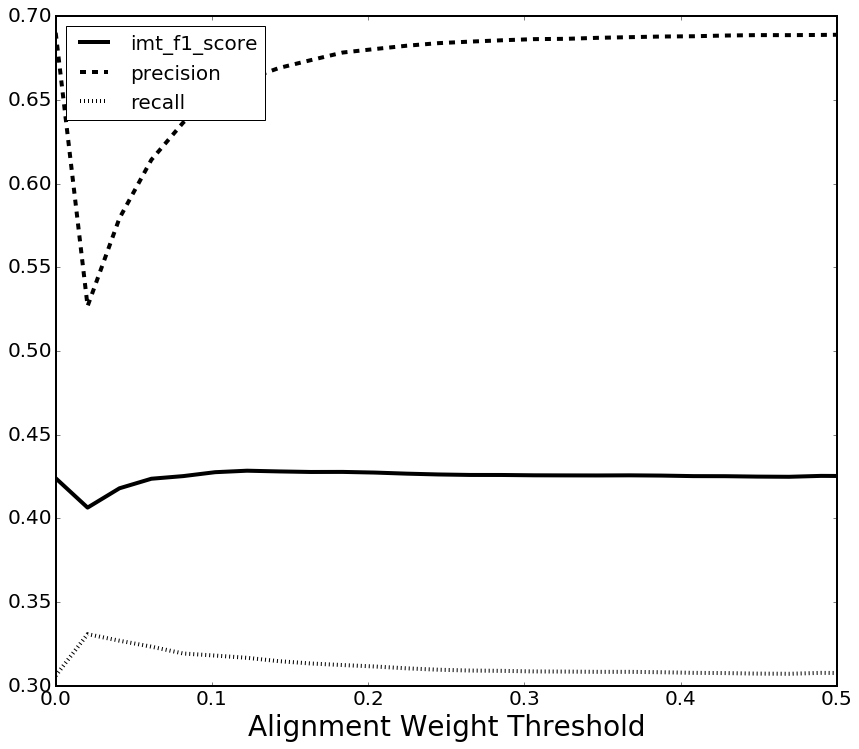

In [89]:
fig, ax = plt.subplots()

names = ['imt_f1_score', 'precision', 'recall']
metrics = [avg_thresh_f1s, t_ps, t_rs]
# styles = 	['solid' | 'dashed', 'dashdot', 'dotted' |
styles = ['solid', 'dashed', 'dotted']


# for i,key_points in enumerate(all_points):

for i in range(len(names)):
    name = names[i]
    x = thresholds
    y = metrics[i]
#     ax.scatter(x, y, s=70, c='red')
    plt.plot(x, y, 'k', label=name, linewidth=4.0, ls=styles[i])
    
    plt.ylim([0.3,0.7])
    plt.xlim([0.0, .5])

    
    
# fig.suptitle('test title')
plt.xlabel('Alignment Weight Threshold', fontsize=28)
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_yticks(ax.get_yticks()[1:])

# plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=14)
# plt.ylabel('ylabel', fontsize=16)
plt.legend()
plt.legend(frameon=False)
plt.legend(loc = 'upper left')


In [20]:
thresholds

array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,
        0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ])

In [ ]:
thresholds = np.linspace

In [17]:
# compare IMT F1 over matching hyps vs raw hyps
raw_f1s, raw_p, raw_r = tuple(np.mean(m) for m in zip(*[imt_f1(h,r) for h,r in zip(hyp_lines,ref_lines)]))
max_f1s, max_p, max_r = tuple(np.mean(m) for m in zip(*[imt_f1(h,r) for h,r in zip(pruned_hyps,ref_lines)]))

print('raw_f1s: {}, raw_p: {}, raw_r: {}'.format(raw_f1s, raw_p, raw_r))
print('max f1s: {}, max_p: {}, max_r: {}'.format(max_f1s, max_p, max_r))

raw_f1s: 0.244294277012, raw_p: 0.245880568086, raw_r: 0.244141178125
max f1s: 0.19325586391, max_p: 0.56001529052, max_r: 0.141309311685


In [ ]:
# now plot p, r, and f1 against alignment thresholds

In [16]:
len(pruned_hyps)

218

In [ ]:
# WORKING: for each target word, print the closest aligned source word
window_size = 1
top_n = 3
for i,t_seq in enumerate(trans):
    for j,w in enumerate(t_seq):
        weights_ij = glimpses[i][j]
        normed_weights = numpy.exp(weights_ij) / numpy.sum(numpy.exp(weights_ij))
        aligned_word = numpy.argmax(weights_ij)
        top_n_aligned_words = numpy.argsort(weights_ij)[::-1][:top_n]
        top_n_aligned_weights = weights_ij[top_n_aligned_words]
        percent_of_best = top_n_aligned_weights / top_n_aligned_weights[0]
        best_weight = top_n_aligned_weights[0]
        avg_weight = numpy.mean(weights_ij)
        best_avg_percent = avg_weight / best_weight
        top_n_src_idxs = [seq[s] for s in top_n_aligned_words]
        src_aligned_idx_window = seq[aligned_word-window_size:aligned_word+window_size+1]
        print('aligned window: {}'.format((self.trg_ivocab[w], [self.src_ivocab[sw] for sw in src_aligned_idx_window])))
        print('top n aligned: {}'.format((self.trg_ivocab[w], [self.src_ivocab[sw] for sw in top_n_src_idxs])))
        print('percent from best: {}'.format(percent_of_best))
        # print('normed weights: {}'.format(weights_ij / numpy.sum(weights_ij)))
        # print('weight distribution: {}'.format(normed_weights))
import ipdb;ipdb.set_trace()

In [16]:
len(glimpses[20])

16

In [10]:
assert len(hyp_lines) == len(ref_lines) == len(glimpses)

TypeError: len() of unsized object

In [ ]:
# Notes BUFFER
# Create the stream used to train a prediction confidence model

# For the baseline, use the thresholded output probability of the word (i.e. the score given the history)

# predict each segement, write out the cost for each word to file

# do post-processing similar to glimpses for each word


# NOTE: ambiguity, aka word-fertility is a consideration here -- 
# model should intuitively have lower confidence at positions which are ambiguous  

# TODO: visualize confidence heatmap over outputs
# TODO: What about forced decoding? how can we get the states, glimpses, and costs for a force-decoded input?